<a href="https://colab.research.google.com/github/bramyeon/sicss-happiness/blob/main/model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>World Happiness:</b> Model Building
Summer Institute in Computational Social Science (SICSS-Korea) 2024 Team Project  

<b>Author:</b> Bryan Nathanael Wijaya ([bryannwijaya@kaist.ac.kr](mailto:bryannwijaya@kaist.ac.kr))  
<b>Team Members (ABC order):</b> Inkoo Kang, Ju Hee Jeung, Kyungmin Lee, Yumi Park

## Preliminaries
This notebook is set to run in Google Colaboratory environment. It assumes that the notebook is located at `/content/drive/My Drive/Colab Notebooks/sicss-korea-2024` and the dataset is saved at `data` directory under the previous path, which in turns contains `clean` and `inference` subdirectories to save preprocessed datasets and inferred life ladder values, respectively. It additionally assumes that there exists a directory named `model` where trained models can be saved. If this is not the case, make sure to modify the `ROOT_DIR` and `DATA_DIR` accordingly, make `clean` and `inference` subdirectories under `DATA_DIR`, and make a `model` directory under `ROOT_DIR`.

## Datasets
Refer to `README.md` in the [GitHub repository](https://github.com/bramyeon/sicss-happiness.git).

### If you find anything suspicious or wrong, do not hesitate to let me know via [email](mailto:bryannwijaya@kaist.ac.kr). Happy coding!


In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")

ROOT_DIR = '/content/drive/My Drive/Colab Notebooks/sicss-korea-2024'
DATA_DIR = 'data'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [ ]:
SEED = 20244078

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [ ]:
for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/clean/world-happiness-2005-2023.csv
/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/clean/world-happiness-2024.csv
/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/clean/temperature-2005-2023.csv
/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/clean/un-gini-index-2005-2023.csv
/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/clean/world-bank-data-2005-2023.csv
/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/clean/combined.csv
/content/drive/My Drive/Colab Notebooks/sicss-korea-2024/data/clean/core.csv


## Data Loading and Preprocessing

There are 4 datasets:
1. `df` is the combined dataset
2. `df_onehot` is the combined dataset with categorical column (i.e., `region`) being transformed into one-hot vector
3. `df_main` is the combined dataset without the extended features from the World Bank
4. `df_main_onehot` is the abovementioned dataset with categorical column (i.e., `region`) being transformed into one-hot vector

Here, for NaN entries, we fill them with the average feature value of the `region` where the `country` belongs in that `year`. However, after this step, if there are still NaN entries, we fill them with the average feature value of the `region` where the `country` belongs regardless of the year. Then, we removed the `country` name which is irrelevant for the model learning. We also visualized the correlation of each features in a heat map.

In [ ]:
df = pd.read_csv(os.path.join(DATA_DIR, "clean/combined.csv"))
df.head(5)

,country,year,region,life ladder,log gdp per capita,social support,healthy life expectancy at birth,freedom to make life choices,generosity,perceptions of corruption,...,"unemployment, total (% of total labor force) (modeled ilo estimate)","unemployment, youth total (% of total labor force ages 15-24) (modeled ilo estimate)",unmet need for contraception (% of married women ages 15-49),urban land area (sq. km),urban population (% of total population),urban population growth (annual %),voice and accountability: estimate,"vulnerable employment, total (% of total employment) (modeled ilo estimate)","wage and salaried workers, total (% of total employment) (modeled ilo estimate)",young people (ages 15-24) newly infected with hiv
0,Afghanistan,2008,South Asia,3.724,7.350,0.451,50.5,0.718,0.164,0.882,...,7.928,10.165,NaN,NaN,23.320,2.893949,-1.168902,90.607746,8.903806,500.0
1,Afghanistan,2009,South Asia,4.402,7.509,0.552,50.8,0.679,0.187,0.850,...,7.923,10.148,NaN,NaN,23.528,4.449269,-1.375495,89.984422,9.409127,500.0
2,Afghanistan,2010,South Asia,4.758,7.614,0.539,51.1,0.600,0.118,0.707,...,7.921,10.133,NaN,NaN,23.737,3.779279,-1.404467,89.316757,9.950540,500.0
3,Afghanistan,2011,South Asia,3.832,7.581,0.521,51.4,0.496,0.160,0.731,...,7.918,10.115,NaN,NaN,23.948,4.574493,-1.335977,88.688147,10.459113,500.0
4,Afghanistan,2012,South Asia,3.783,7.661,0.521,51.7,0.531,0.234,0.776,...,7.914,10.098,NaN,NaN,24.160,4.958981,-1.267430,87.943290,11.037459,500.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Columns: 251 entries, country to young people (ages 15-24) newly infected with hiv
dtypes: float64(248), int64(1), object(2)
memory usage: 4.5+ MB


In [ ]:
df.isna().sum()

country                                                                              0
year                                                                                 0
region                                                                               0
life ladder                                                                          0
log gdp per capita                                                                  28
                                                                                  ... 
urban population growth (annual %)                                                 184
voice and accountability: estimate                                                 168
vulnerable employment, total (% of total employment) (modeled ilo estimate)        185
wage and salaried workers, total (% of total employment) (modeled ilo estimate)    185
young people (ages 15-24) newly infected with hiv                                  796
Length: 251, dtype: int64

In [ ]:
for col in df.columns[3:]:
    # first, try to fill NaNs with the average of the region in the same year
    region_mean = df.groupby(['region', 'year'])[col].transform('mean')
    df[col] = df[col].fillna(region_mean)

df.isna().sum()

country                                                                              0
year                                                                                 0
region                                                                               0
life ladder                                                                          0
log gdp per capita                                                                   0
                                                                                  ... 
urban population growth (annual %)                                                 138
voice and accountability: estimate                                                 138
vulnerable employment, total (% of total employment) (modeled ilo estimate)        138
wage and salaried workers, total (% of total employment) (modeled ilo estimate)    138
young people (ages 15-24) newly infected with hiv                                  153
Length: 251, dtype: int64

In [ ]:
for col in df.columns[3:]:
    # if there is no data for that region in that year, fill with the average of the region regardless of the year
    region_mean = df.groupby('region')[col].transform('mean')
    df[col] = df[col].fillna(region_mean)

df.isna().sum()

country                                                                            0
year                                                                               0
region                                                                             0
life ladder                                                                        0
log gdp per capita                                                                 0
                                                                                  ..
urban population growth (annual %)                                                 0
voice and accountability: estimate                                                 0
vulnerable employment, total (% of total employment) (modeled ilo estimate)        0
wage and salaried workers, total (% of total employment) (modeled ilo estimate)    0
young people (ages 15-24) newly infected with hiv                                  0
Length: 251, dtype: int64

In [ ]:
df_main = df[df.columns[:13]]
df_main.head(5)

,country,year,region,life ladder,log gdp per capita,social support,healthy life expectancy at birth,freedom to make life choices,generosity,perceptions of corruption,positive affect,negative affect,avg temperature
0,Afghanistan,2008,South Asia,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258,76.139933
1,Afghanistan,2009,South Asia,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237,77.710964
2,Afghanistan,2010,South Asia,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275,77.937442
3,Afghanistan,2011,South Asia,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267,76.147259
4,Afghanistan,2012,South Asia,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268,76.240899


In [ ]:
df_main_onehot = pd.get_dummies(df_main, columns=['region'], dtype=float)
del df_main_onehot['country']

df_main_onehot.head(5)

,year,life ladder,log gdp per capita,social support,healthy life expectancy at birth,freedom to make life choices,generosity,perceptions of corruption,positive affect,negative affect,...,region_Central and Eastern Europe,region_Commonwealth of Independent States,region_East Asia,region_Latin America and Caribbean,region_Middle East and North Africa,region_North America and ANZ,region_South Asia,region_Southeast Asia,region_Sub-Saharan Africa,region_Western Europe
0,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
df_main_onehot.isna().sum()

year                                         0
life ladder                                  0
log gdp per capita                           0
social support                               0
healthy life expectancy at birth             0
freedom to make life choices                 0
generosity                                   0
perceptions of corruption                    0
positive affect                              0
negative affect                              0
avg temperature                              0
region_Central and Eastern Europe            0
region_Commonwealth of Independent States    0
region_East Asia                             0
region_Latin America and Caribbean           0
region_Middle East and North Africa          0
region_North America and ANZ                 0
region_South Asia                            0
region_Southeast Asia                        0
region_Sub-Saharan Africa                    0
region_Western Europe                        0
dtype: int64

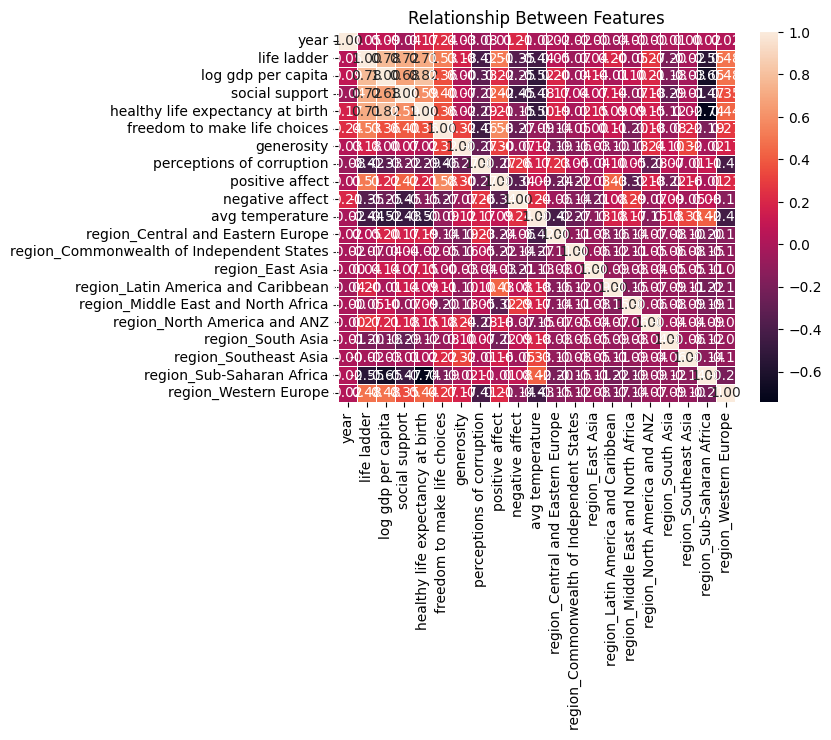

In [ ]:
df_main_onehot_corr_matrix = df_main_onehot.corr()
sns.heatmap(df_main_onehot_corr_matrix, annot = True, fmt ='.2f', linewidth = .7)
plt.title('Relationship Between Features')
plt.show()

In [ ]:
df_onehot = pd.get_dummies(df, columns=['region'], dtype=float)
del df_onehot['country']

df_onehot.head(5)

,year,life ladder,log gdp per capita,social support,healthy life expectancy at birth,freedom to make life choices,generosity,perceptions of corruption,positive affect,negative affect,...,region_Central and Eastern Europe,region_Commonwealth of Independent States,region_East Asia,region_Latin America and Caribbean,region_Middle East and North Africa,region_North America and ANZ,region_South Asia,region_Southeast Asia,region_Sub-Saharan Africa,region_Western Europe
0,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Columns: 259 entries, year to region_Western Europe
dtypes: float64(258), int64(1)
memory usage: 4.7 MB


In [ ]:
df_onehot.isnull().sum()

year                                0
life ladder                         0
log gdp per capita                  0
social support                      0
healthy life expectancy at birth    0
                                   ..
region_North America and ANZ        0
region_South Asia                   0
region_Southeast Asia               0
region_Sub-Saharan Africa           0
region_Western Europe               0
Length: 259, dtype: int64

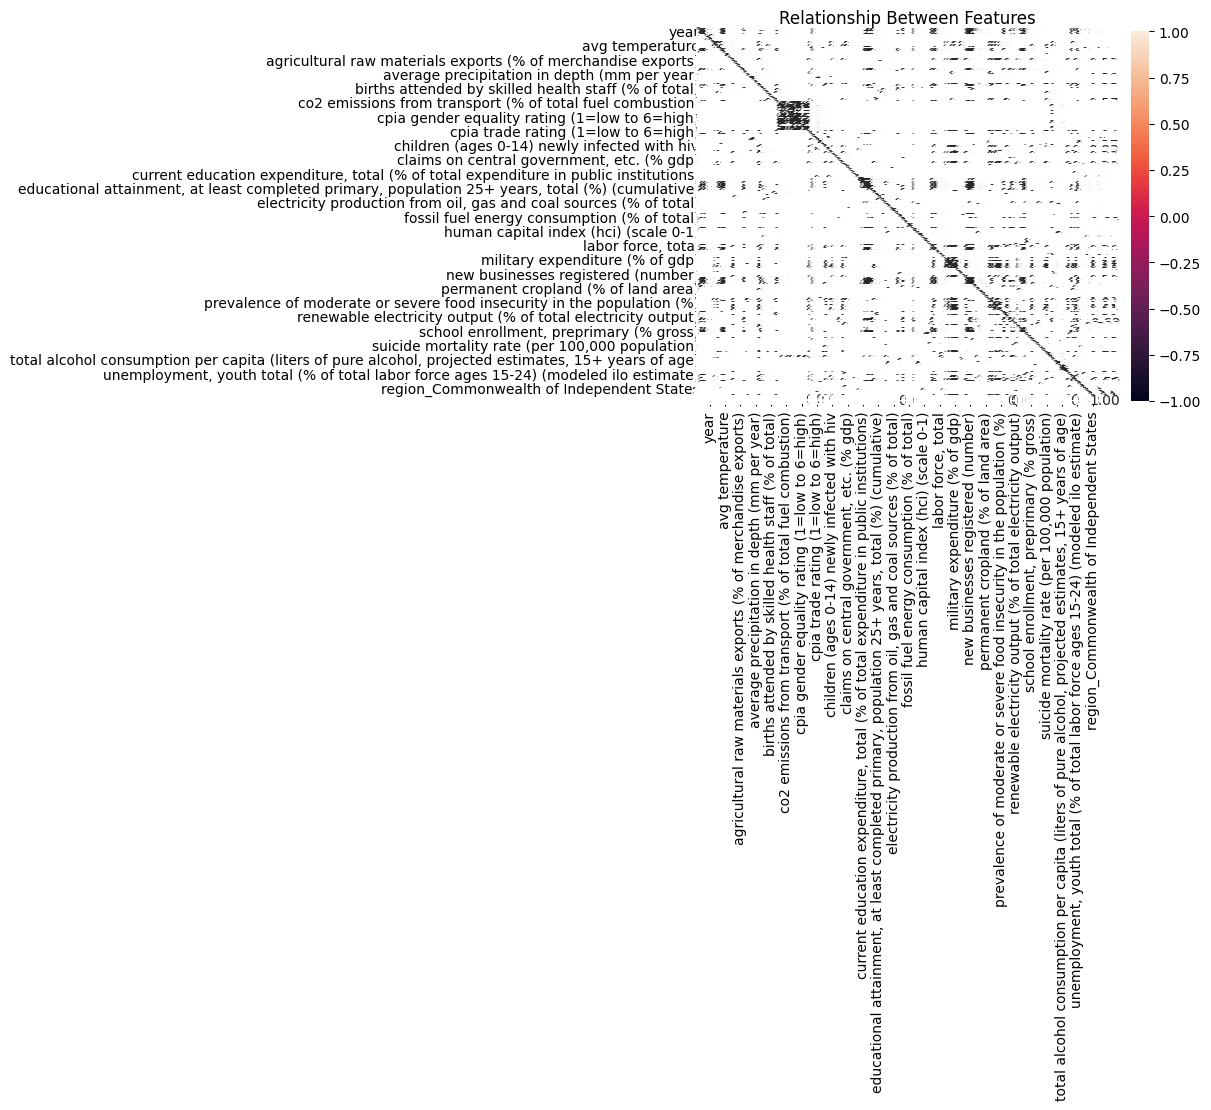

In [ ]:
df_onehot_corr_matrix = df_onehot.corr()
sns.heatmap(df_onehot_corr_matrix, annot = True, fmt ='.2f', linewidth = .7)
plt.title('Relationship Between Features')
plt.show()

## Train/Test Splitting

Train split consists of the data in 2005-2022, while test split consists of the data in 2023. Here, we remove irrelevant features such as the `year` of the data record. We have two sets of training and testing data loaders.
1. `main_train_loader` and `main_test_loader`: The loader for model built upon only the main features
2. `train_loader` and `test_loader`: The loader for model built upon all features, including those from the World Bank

In [ ]:
BATCH_SIZE = 32

In [ ]:
df_main_onehot['bias'] = -1.

df_main_train = df_main_onehot[df_main_onehot['year'] != 2023]
df_main_test = df_main_onehot[df_main_onehot['year'] == 2023]

del df_main_train['year']
del df_main_test['year']

df_main_train_label = torch.tensor(df_main_train['life ladder'].tolist(), dtype=torch.float).to(device)
df_main_test_label = torch.tensor(df_main_test['life ladder'].tolist(), dtype=torch.float).to(device)

del df_main_train['life ladder']
del df_main_test['life ladder']

df_main_train_data = torch.tensor(df_main_train.values, dtype=torch.float).to(device)
df_main_test_data = torch.tensor(df_main_test.values, dtype=torch.float).to(device)

df_main_train_data.shape, df_main_train_label.shape, df_main_test_data.shape, df_main_test_label.shape

(torch.Size([2225, 20]),
 torch.Size([2225]),
 torch.Size([138, 20]),
 torch.Size([138]))

In [ ]:
main_train_dataset = torch.utils.data.TensorDataset(df_main_train_data, df_main_train_label)
main_test_dataset = torch.utils.data.TensorDataset(df_main_test_data, df_main_test_label)

main_train_loader = torch.utils.data.DataLoader(main_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
main_test_loader = torch.utils.data.DataLoader(main_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
df_onehot['bias'] = -1.

df_train = df_onehot[df_onehot['year'] != 2023]
df_test = df_onehot[df_onehot['year'] == 2023]

del df_train['year']
del df_test['year']

df_train_label = torch.tensor(df_train['life ladder'].tolist(), dtype=torch.float).to(device)
df_test_label = torch.tensor(df_test['life ladder'].tolist(), dtype=torch.float).to(device)

del df_train['life ladder']
del df_test['life ladder']

df_train_data = torch.tensor(df_train.values, dtype=torch.float).to(device)
df_test_data = torch.tensor(df_test.values, dtype=torch.float).to(device)

df_train_data.shape, df_train_label.shape, df_test_data.shape, df_test_label.shape

<ipython-input-23-5679a387f01f>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_onehot['bias'] = -1.


(torch.Size([2225, 258]),
 torch.Size([2225]),
 torch.Size([138, 258]),
 torch.Size([138]))

In [ ]:
train_dataset = torch.utils.data.TensorDataset(df_train_data, df_train_label)
test_dataset = torch.utils.data.TensorDataset(df_test_data, df_test_label)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
main_in = df_main_train_data.shape[1]
all_in = df_train_data.shape[1]

main_in, all_in

(20, 258)

## Model Building and Initialization

We built 5 models for each case (i.e., main and complex model depending on the number of features considered) with different number of layers, thus different complexity. The model is based on vanilla neural network.

In [ ]:
class Regressor(nn.Module):
    def __init__(self, features):
        super(Regressor, self).__init__()


        self.layers = []
        for i in range(len(features)-1):
            self.layers.append(nn.Linear(features[i], features[i+1]))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(features[-1], 1))

        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
model = Regressor([20, 45, 32, 42, 256])
input_test = torch.randn((534,20))
output = model(input_test)
print(output.size())

torch.Size([534, 1])


In [ ]:
LUCKY_NUMBER = 42

lr = 0.001
epochs = 200
beta1, beta2 = 0.9, 0.999
criterion = nn.MSELoss()

In [ ]:
class Model:
    def __init__(self, features, lr, beta1, beta2, epochs):
        self.features = features
        self.model = Regressor(self.features)
        self.model = self.model.to(device)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epochs = epochs
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        self.train_loss_epoch = None
        self.test_err_epoch = None

    def update(self, train_loss_epoch, test_err_epoch):
        self.train_loss_epoch = train_loss_epoch
        self.test_err_epoch = test_err_epoch

In [ ]:
main_models = [ Model([main_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER*4, LUCKY_NUMBER*8, LUCKY_NUMBER*16, LUCKY_NUMBER*8, LUCKY_NUMBER*4, LUCKY_NUMBER*2, LUCKY_NUMBER], lr, beta1, beta2, epochs),
                Model([main_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER*4, LUCKY_NUMBER*8, LUCKY_NUMBER*4, LUCKY_NUMBER*2, LUCKY_NUMBER], lr, beta1, beta2, epochs),
                Model([main_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER*4, LUCKY_NUMBER*2, LUCKY_NUMBER], lr, beta1, beta2, epochs),
                Model([main_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER], lr, beta1, beta2, epochs),
                Model([main_in, LUCKY_NUMBER], lr, beta1, beta2, epochs) ]


In [ ]:
lr_ = lr

models = [  Model([all_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER*4, LUCKY_NUMBER*8, LUCKY_NUMBER*16, LUCKY_NUMBER*8, LUCKY_NUMBER*4, LUCKY_NUMBER*2, LUCKY_NUMBER], lr_, beta1, beta2, epochs),
            Model([all_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER*4, LUCKY_NUMBER*8, LUCKY_NUMBER*4, LUCKY_NUMBER*2, LUCKY_NUMBER], lr_, beta1, beta2, epochs),
            Model([all_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER*4, LUCKY_NUMBER*2, LUCKY_NUMBER], lr_, beta1, beta2, epochs),
            Model([all_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER], lr_, beta1, beta2, epochs),
            Model([all_in, LUCKY_NUMBER], lr_, beta1, beta2, epochs) ]

## Model Training

In [ ]:
def train(model, trainloader, criterion):

    model.model.train()
    losses = []

    for i, (data, label) in enumerate(trainloader):
        data, label = data.to(device), label.to(device)
        model.optimizer.zero_grad()
        output = model.model(data)
        loss = criterion(output, label.reshape(-1,1))
        losses.append(loss)
        loss.backward()
        model.optimizer.step()

    loss_epoch = sum(losses)/len(losses)
    return loss_epoch.item()

In [ ]:
def eval(model, testloader, show=False):

    model.model.eval()

    sums = []
    labels = []
    outputs = []
    with torch.no_grad():
        for i, (data, label) in enumerate(testloader):
            data, label = data.to(device), label.to(device)
            output = model.model(data)
            squared_error = (output - label.reshape(-1,1))**2
            sum_squared_error = torch.sum(squared_error)
            sums.append(sum_squared_error)
            if show:
                labels += label.tolist()
                outputs += [elem[0] for elem in output.tolist()]

    error_epoch = sum(sums)/len(sums)
    result = pd.DataFrame({'label': labels, 'output': outputs})
    return error_epoch.item(), result

In [ ]:
for i in range(len(main_models)):
    print(f"\nTraining for MAIN (only 20 features) model with features={main_models[i].features}, lr={main_models[i].lr}, beta1={main_models[i].beta1}, beta2={main_models[i].beta2}, epochs={main_models[i].epochs}")
    train_loss_epoch = []
    test_err_epoch = []
    show = False
    for epoch in range(main_models[i].epochs):
        if epoch == main_models[i].epochs-1:
            show = True
        train_loss_epoch.append(train(main_models[i], main_train_loader, criterion))
        test_err, result = eval(main_models[i], main_test_loader, show=show)
        test_err_epoch.append(test_err)
        if (epoch+1) % 20 == 0:
            print(f'Epoch: {epoch+1}\tTrain Loss: {train_loss_epoch[-1]:5.2f}\tTest Sum of Squared Error: {test_err_epoch[-1]:7.2f}')
            torch.save(main_models[i].model.state_dict(), os.path.join(ROOT_DIR, f'model/main-{len(main_models[i].features)}layers-{epoch+1}epochs.pth'))
        if show:
            result.to_csv(os.path.join(DATA_DIR, f'inference/main-{len(main_models[i].features)}layers-{epoch+1}epochs.csv'), index=False)
    main_models[i].update(train_loss_epoch, test_err_epoch)


Training for MAIN (only 20 features) model with features=[20, 42, 84, 168, 336, 672, 336, 168, 84, 42], lr=0.001, beta1=0.9, beta2=0.999, epochs=200
Epoch: 20	Train Loss:  0.33	Test Sum of Squared Error:   10.17
Epoch: 40	Train Loss:  0.28	Test Sum of Squared Error:   10.83
Epoch: 60	Train Loss:  0.36	Test Sum of Squared Error:   15.35
Epoch: 80	Train Loss:  0.29	Test Sum of Squared Error:   20.94
Epoch: 100	Train Loss:  0.24	Test Sum of Squared Error:    9.09
Epoch: 120	Train Loss:  0.25	Test Sum of Squared Error:    7.36
Epoch: 140	Train Loss:  0.23	Test Sum of Squared Error:    7.61
Epoch: 160	Train Loss:  0.24	Test Sum of Squared Error:    9.33
Epoch: 180	Train Loss:  0.24	Test Sum of Squared Error:   12.73
Epoch: 200	Train Loss:  0.24	Test Sum of Squared Error:    7.28

Training for MAIN (only 20 features) model with features=[20, 42, 84, 168, 336, 168, 84, 42], lr=0.001, beta1=0.9, beta2=0.999, epochs=200
Epoch: 20	Train Loss:  0.32	Test Sum of Squared Error:   10.39
Epoch: 40	T

In [ ]:
for i in range(len(models)):
    print(f"\nTraining for COMPLEX (extended features) model with features={models[i].features}, lr={models[i].lr}, beta1={models[i].beta1}, beta2={models[i].beta2}, epochs={models[i].epochs}")
    train_loss_epoch = []
    test_err_epoch = []
    show = False
    for epoch in range(models[i].epochs):
        if epoch == models[i].epochs-1:
            show = True
        train_loss_epoch.append(train(models[i], train_loader, criterion))
        test_err, result = eval(models[i], test_loader, show=show)
        test_err_epoch.append(test_err)
        if (epoch+1) % 20 == 0:
            print(f'Epoch: {epoch+1}\tTrain Loss: {train_loss_epoch[-1]:5.2f}\tTest Sum of Squared Error: {test_err_epoch[-1]:7.2f}')
            torch.save(models[i].model.state_dict(), os.path.join(ROOT_DIR, f'model/complex-{len(models[i].features)}layers-{epoch+1}epochs.pth'))
        if show:
            result.to_csv(os.path.join(DATA_DIR, f'inference/complex-{len(models[i].features)}layers-{epoch+1}epochs.csv'), index=False)
    models[i].update(train_loss_epoch, test_err_epoch)


Training for COMPLEX (extended features) model with features=[258, 42, 84, 168, 336, 672, 336, 168, 84, 42], lr=0.001, beta1=0.9, beta2=0.999, epochs=200
Epoch: 20	Train Loss:   nan	Test Sum of Squared Error:     nan
Epoch: 40	Train Loss:   nan	Test Sum of Squared Error:     nan
Epoch: 60	Train Loss:   nan	Test Sum of Squared Error:     nan
Epoch: 80	Train Loss:   nan	Test Sum of Squared Error:     nan
Epoch: 100	Train Loss:   nan	Test Sum of Squared Error:     nan
Epoch: 120	Train Loss:   nan	Test Sum of Squared Error:     nan
Epoch: 140	Train Loss:   nan	Test Sum of Squared Error:     nan
Epoch: 160	Train Loss:   nan	Test Sum of Squared Error:     nan
Epoch: 180	Train Loss:   nan	Test Sum of Squared Error:     nan
Epoch: 200	Train Loss:   nan	Test Sum of Squared Error:     nan

Training for COMPLEX (extended features) model with features=[258, 42, 84, 168, 336, 168, 84, 42], lr=0.001, beta1=0.9, beta2=0.999, epochs=200
Epoch: 20	Train Loss:   nan	Test Sum of Squared Error:     nan
E

## Plotting

We visualize the training results here. As shown, the complex models based on multiple features failed to converge, so further tuning may be necessary. This is likely due to explosing gradients or infinitely small gradients... since we have way mor efeatures now (?)

In [42]:
def plot(models, label):
    figure = plt.figure(figsize=(12,4))

    f1 = figure.add_subplot(121)
    f2 = figure.add_subplot(122)

    for model in models:
        epochs = range(1, model.epochs+1)
        f1.plot(epochs, model.train_loss_epoch, label=f'{label} model, {len(model.features)} layers')
    f1.set_title(f'Training loss (MSE Loss)')
    f1.set_xlabel('Epochs')
    f1.set_ylabel('Training Loss')
    f1.legend()

    for model in models:
        f2.plot(epochs, model.test_err_epoch, label=f'{label} model, {len(model.features)} layers')
    f2.set_title(f'Sum of squared error on testing dataset')
    f2.set_xlabel('Epochs')
    f2.set_ylabel('Test sum of squared error')
    f2.legend()

    plt.show()
    print()
    for model in models:
        print(f"Sum of squared error on testing dataset for {label.lower()} model with {len(model.features)} layers:\t{model.test_err_epoch[-1]:.4f}")

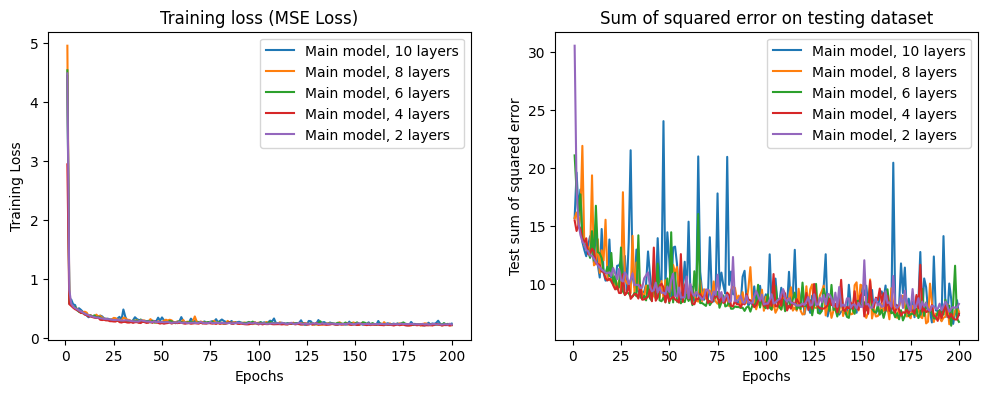


Sum of squared error on testing dataset for main model with 10 layers:	7.2846
Sum of squared error on testing dataset for main model with 8 layers:	7.5706
Sum of squared error on testing dataset for main model with 6 layers:	6.7061
Sum of squared error on testing dataset for main model with 4 layers:	7.4013
Sum of squared error on testing dataset for main model with 2 layers:	8.2509


In [43]:
plot(main_models, "Main")

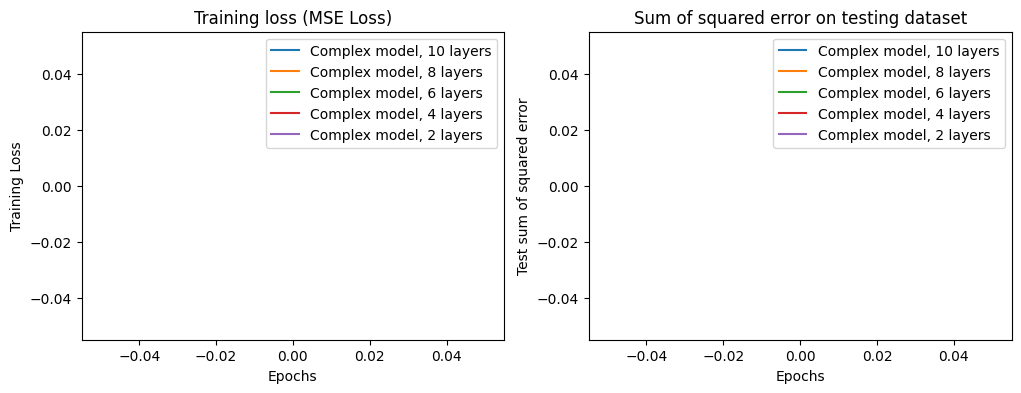


Sum of squared error on testing dataset for complex model with 10 layers:	nan
Sum of squared error on testing dataset for complex model with 8 layers:	nan
Sum of squared error on testing dataset for complex model with 6 layers:	nan
Sum of squared error on testing dataset for complex model with 4 layers:	nan
Sum of squared error on testing dataset for complex model with 2 layers:	nan


In [44]:
plot(models, "Complex")

## Example Usage

In [45]:
model = Model([main_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER], lr, beta1, beta2, epochs)
checkpoint = torch.load(os.path.join(ROOT_DIR, 'model/main-4layers-200epochs.pth'))
model.model.load_state_dict(checkpoint)
model.model.to(device)

Regressor(
  (model): Sequential(
    (0): Linear(in_features=20, out_features=42, bias=True)
    (1): ReLU()
    (2): Linear(in_features=42, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=42, bias=True)
    (5): ReLU()
    (6): Linear(in_features=42, out_features=1, bias=True)
  )
)

In [46]:
data = df_main_test_data
label = df_main_test_label

In [47]:
model.model.eval()

labels = []
outputs = []
with torch.no_grad():
    data, label = data.to(device), label.to(device)
    output = model.model(data)
    squared_error = (output - label.reshape(-1,1))**2
    mean_squared_error = torch.sum(squared_error)/len(squared_error)
    if show:
        labels += label.tolist()
        outputs += [elem[0] for elem in output.tolist()]

result = pd.DataFrame({'label': labels, 'output': outputs})

print(f'MSE: {mean_squared_error:.4f}\n')
result.head(30)

MSE: 0.2682



,label,output
0,1.446,3.285849
1,5.445,5.489554
2,6.393,6.179706
3,5.679,5.087801
4,7.025,7.144991
5,6.636,6.870047
6,5.214,5.172686
7,5.959,6.166353
8,4.114,4.066794
9,6.944,6.827020
